In [ ]:
from sklearn.manifold import TSNE
import argparse
from dataloaders import awa2_dataloader
from models.SECBM import SemanticCBM
import torch
import os
from tqdm import tqdm
import numpy as np
# load models
## NO GROUP
# ON AWA
os.getcwd()
os.chdir('/home/disk/qij/')
model_path = os.path.join('/home/disk/qij/SE-CBM-group/FinalCheckpoints_0714/AwA2/12_32/ViP-CEM-anchor/Seed_3407', '224.pth')

# select 3 concepts and 2 classes

# select data
parser = argparse.ArgumentParser(description='manual to this script')
parser.add_argument("--dataroot", type=str, default='/home/disk/qij/AwA2/Animals_with_Attributes2')
parser.add_argument("--batch-size", type=int, default=128)
parser.add_argument("--img-size", type=int, default=256)
parser.add_argument('--workers', type=int, default=8)
parser.add_argument('--USE_IMAGENET_INCEPTION', type=bool, default=True)
parser.add_argument('--train-val-test-ratio', type=list, default=[0.6, 0.1, 0.3])
parser.add_argument('--used-group', type=list, default=None)
parser.add_argument('--normalized', type=bool, default=False)

parser.add_argument('--device', type=str, default='cuda:1')
args = parser.parse_args(args=[])

# args.device = 'cpu'
# 3. datasets and models
dataloaders, class2index, concept2index, attr_group_dict, group_size = awa2_dataloader.load_data(args)
print(f'concept groups: {attr_group_dict}')# , attr_group_dict)
print(f'group size: {group_size}')
print('=======================================================')
# dataloaders, attr2index, class2index, attr_group_dict, group_size = cub_dataloader.load_data(args)

channel = 12
emb_dim = 32
n_classes = 50
# nonlinear = False
device = torch.device(args.device if torch.cuda.is_available() else 'cpu')

: 

In [7]:
model = SemanticCBM(8, channel, emb_dim, attr_group_dict, device, 'joint', n_classes, nonlinear=False, use_group=True, use_emb=True, use_logits=True, anchor_model=2, shift='none', explaining=True).to(device)
model.load_state_dict(torch.load(model_path))
# train
model.eval()

u_list = []
y_list = []
c_list = []
for samples in tqdm(dataloaders['test']):
    images, labels, concepts = samples['image'], samples['class_label'], samples['concept_label']
    x, y, c = images.to(device), labels.to(device).squeeze().type(torch.long), concepts.to(device)
    u = model(x, c)# .detach().cpu().numpy() # (N, K, m)
    c_list.append(c.detach().cpu().numpy())
    u_list.append(u.detach().cpu().numpy())
    y_list.append(y.detach().cpu().numpy())

u = np.concatenate(u_list, 0)
c = np.concatenate(c_list, 0)
y = np.concatenate(y_list, 0)

print(class2index, concept2index)

100%|██████████| 88/88 [00:37<00:00,  2.37it/s]


{'antelope': 0, 'grizzly+bear': 1, 'killer+whale': 2, 'beaver': 3, 'dalmatian': 4, 'persian+cat': 5, 'horse': 6, 'german+shepherd': 7, 'blue+whale': 8, 'siamese+cat': 9, 'skunk': 10, 'mole': 11, 'tiger': 12, 'hippopotamus': 13, 'leopard': 14, 'moose': 15, 'spider+monkey': 16, 'humpback+whale': 17, 'elephant': 18, 'gorilla': 19, 'ox': 20, 'fox': 21, 'sheep': 22, 'seal': 23, 'chimpanzee': 24, 'hamster': 25, 'squirrel': 26, 'rhinoceros': 27, 'rabbit': 28, 'bat': 29, 'giraffe': 30, 'wolf': 31, 'chihuahua': 32, 'rat': 33, 'weasel': 34, 'otter': 35, 'buffalo': 36, 'zebra': 37, 'giant+panda': 38, 'deer': 39, 'bobcat': 40, 'pig': 41, 'lion': 42, 'mouse': 43, 'polar+bear': 44, 'collie': 45, 'walrus': 46, 'raccoon': 47, 'cow': 48, 'dolphin': 49} {'black': 0, 'white': 1, 'blue': 2, 'brown': 3, 'gray': 4, 'orange': 5, 'red': 6, 'yellow': 7, 'patches': 8, 'spots': 9, 'stripes': 10, 'furry': 11, 'hairless': 12, 'toughskin': 13, 'big': 14, 'small': 15, 'bulbous': 16, 'lean': 17, 'flippers': 18, 'hand

Class: douphin, cow

concepts: black, white, blue

(392,) (285,)
(392, 3, 12) (285, 3, 12)
(677, 2)


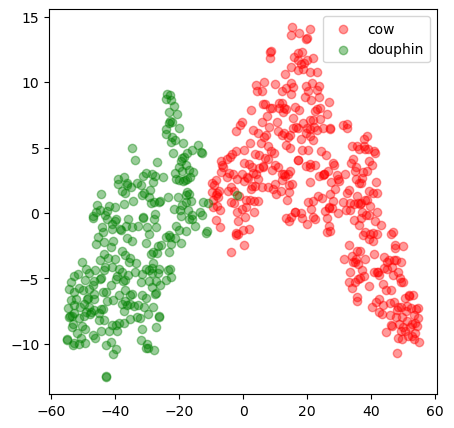

In [8]:
classes = [48, 49] # cow, dophin
concepts = [0, 1, 2] # black, white, blue

# embeddings with cow and dophin
y_cow = np.argwhere(y==48)[:,0]
y_dophin = np.argwhere(y==49)[:,0]
print(y_cow.shape, y_dophin.shape)

# u_cow = u[y_cow,0:3,:]
# u_dophin = u[y_dophin,0:3,:]
z_cow = u[y_cow,0:3,:]
z_dophin = u[y_dophin,0:3,:]
print(z_cow.shape, z_dophin.shape)
n_c, n_d = z_cow.shape[0], z_dophin.shape[0]
z_cow = z_cow.reshape(n_c, -1)
z_dophin = z_dophin.reshape(n_d, -1)
z = np.concatenate([z_cow, z_dophin], 0)
X_tsne = TSNE(n_components=2,random_state=33).fit_transform(z)
print(X_tsne.shape)
colors = ['r', 'g']
img_dir = "SE-CBM-group"
import matplotlib.pyplot as plt
plt.figure(figsize=[5,5])
plt.scatter(X_tsne[0:n_c,0], X_tsne[0:n_c,1], c='r', label='cow', alpha=0.4)
plt.scatter(X_tsne[n_c:,0], X_tsne[n_c:,1], c='g', label='douphin', alpha=0.4)
plt.legend()
plt.savefig('SE-CBM-group/digits_tsne_Z.pdf')
plt.show()

In [4]:
# define labels for each components
n_c, n_d = u_cow.shape[0], u_dophin.shape[0]
# randomly select 500

uc = u_cow.transpose(1,0,2).reshape(-1, 12)
ud = u_dophin.transpose(1,0,2).reshape(-1, 12)
lc = np.array([0,1,2]).repeat(n_c)
ld = np.array([3, 4, 5]).repeat(n_d)
u_emb = np.concatenate([uc, ud], 0)
l_emb = np.concatenate([lc, ld], 0)
print(u_emb, l_emb)
print(u_cow[0,0],  u_cow[1,0])
'''
X_tsne = TSNE(n_components=2,random_state=33).fit_transform(digits.data)

ckpt_dir="images"
if not os.path.exists(ckpt_dir):
    os.makedirs(ckpt_dir)

plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=digits.target,label="t-SNE")
plt.legend()
plt.subplot(122)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=digits.target,label="PCA")
plt.legend()
plt.savefig('images/digits_tsne-pca.png', dpi=120)
plt.show()
'''

[[-0.28939882 -0.14445843 -2.7132056  ... -1.1110076  -0.53530025
  -0.7871777 ]
 [-0.37102714 -0.50211906 -2.4463942  ... -1.6055012  -0.37847134
  -0.6915264 ]
 [-0.4933162  -0.22352512 -2.4866548  ... -1.5099397  -0.3692004
  -0.6637208 ]
 ...
 [-1.1309242   0.43734357 -3.2277794  ... -0.69628507  0.30285197
  -0.10790887]
 [-0.6881683   0.59795594 -2.617177   ...  0.65910655 -0.01377797
  -0.6030827 ]
 [-0.44480112  1.5923393  -2.008342   ...  0.9057543  -0.03548758
  -0.15560395]] [0 0 0 ... 5 5 5]
[-0.28939882 -0.14445843 -2.7132056   0.06386753 -1.1882001  -0.96686405
 -3.7893443   5.653763    2.3108335  -1.1110076  -0.53530025 -0.7871777 ] [-0.37102714 -0.50211906 -2.4463942   0.10699953 -1.5697373  -0.9831806
 -3.4774933   4.158093    1.2125471  -1.6055012  -0.37847134 -0.6915264 ]


'\nX_tsne = TSNE(n_components=2,random_state=33).fit_transform(digits.data)\n\nckpt_dir="images"\nif not os.path.exists(ckpt_dir):\n    os.makedirs(ckpt_dir)\n\nplt.figure(figsize=(10, 5))\nplt.subplot(121)\nplt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=digits.target,label="t-SNE")\nplt.legend()\nplt.subplot(122)\nplt.scatter(X_pca[:, 0], X_pca[:, 1], c=digits.target,label="PCA")\nplt.legend()\nplt.savefig(\'images/digits_tsne-pca.png\', dpi=120)\nplt.show()\n'

X_tsne = TSNE(n_components=2,random_state=33).fit_transform(digits.data)

fig_dir = 'AwA2/predicate-matrix-from-zip.png'
if not os.path.exists(ckpt_dir):
    os.makedirs(ckpt_dir)

plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=digits.target,label="t-SNE")
plt.legend()
plt.subplot(122)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=digits.target,label="PCA")
plt.legend()
plt.savefig('images/digits_tsne-pca.png', dpi=120)
plt.show()

(2031, 2)
1176 1461
1461 1746
1746 2031


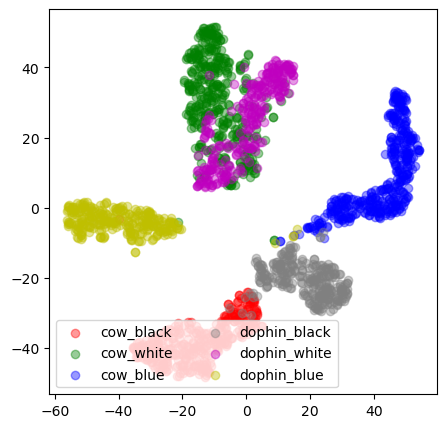

In [5]:
X_tsne = TSNE(n_components=2,random_state=33).fit_transform(u_emb)
print(X_tsne.shape)
colors = ['r', 'g', 'b', 'grey', 'm', 'y']
labels = ['black', 'white', 'blue']
img_dir = "SE-CBM-group"
import matplotlib.pyplot as plt
plt.figure(figsize=[5,5])
for i in range(3):
    plt.scatter(X_tsne[i*n_c: (i+1) * n_c, 0], X_tsne[i*n_c: (i+1) * n_c, 1], c=colors[i], label="cow_" + labels[i], alpha=0.4)
for i in range(3):
    print(3 * n_c + i*n_d, 3* n_c + (i+1) * n_d)
    plt.scatter(X_tsne[3 * n_c + i*n_d: 3* n_c + (i+1) * n_d, 0], X_tsne[3 * n_c + i*n_d: 3* n_c + (i+1) * n_d, 1], c=colors[i+3], label="dophin_" + labels[i], alpha=0.4)
plt.legend(ncol=2, loc=3)
plt.savefig('SE-CBM-group/digits_tsne_LP.pdf')
plt.show()